In [84]:
import os

import imageio
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

import utoolbox.utils.files as fileutils
from utoolbox.container import Raster
from utoolbox.container.layouts import Volume

#### Load image

In [82]:
source_folder = os.path.join(*["data", "membrane_seg"])
file_list = fileutils.list_files(
    source_folder,
    name_filters=[
        fileutils.ExtensionFilter('tif')
    ]
)

fid = 0
print("[{}]={}".format(fid, file_list[fid]))

image = Raster(file_list[fid], layout=Volume, spacing=(.100319, .102, .102))
print("layout={}".format(image.metadata.layout))

image_sitk = image.to_sitk()

[0]=data/membrane_seg/sample1.tif
layout=<class 'utoolbox.container.layouts.Volume'>


#### Speed function 1/(x+1)

In [69]:
speed_func = 1 / (image+1)

#### Find centroid

In [101]:
from scipy.ndimage import measurements
com = measurements.center_of_mass(image.view(np.ndarray))
com = tuple(np.floor(com))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

In [ ]:
com

#### Generate distance map

In [104]:
nz, ny, nx = image.shape
cz = com[0]
cy = com[1]
cx = com[2]

seed = sitk.Image(nx, ny, nz, sitk.sitkUInt8)
seed.SetSpacing(image_sitk.GetSpacing())
seed.SetOrigin(image_sitk.GetOrigin())
seed.SetDirection(image_sitk.GetDirection())

seed[int(cx), int(cy), int(cz)] = 1

seed_distance = sitk.SignedMaurerDistanceMap(
    seed, insideIsPositive=True, useImageSpacing=True
)
init = sitk.BinaryThreshold(seed_distance, -20, 0)
sitk.Show(init)

In [71]:
edges = 1 - speed_func
edges[edges < 0] = 0

In [75]:
cx = np.mean(image * gx)
cy = np.mean(image * gy)
cz = np.mean(image * gz)
print("(x, y, z) = ({}, {}, {})".format(cx, cy, cz))

(x, y, z) = (1488.9300491024376, 7953.237770807674, 8288.357771641457)


In [73]:
edges.save("data/edges.tif")

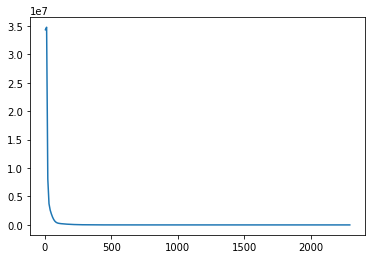

In [36]:
from skimage.exposure import histogram
hist = histogram(speed_func, nbins=256)
plt.plot(hist[1], hist[0])

In [34]:
def outliers_modified_z_score(ys):
    threshold = 3.5

    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return np.abs(modified_z_scores)

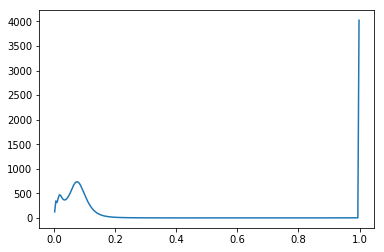

In [35]:
plt.plot(hist[1], outliers_modified_z_score(hist[0]))

In [ ]:
image_itk = itk.GetImageFromArray(image)

In [ ]:
float_t = itk.Image[itk.F, 3]
int_t = itk.Image[itk.US, 3]

In [ ]:
BoundedReciprocalImageFilterType = itk.BoundedReciprocalImageFilter[float_t, float_t]
BoundedReciprocalImageFilter = BoundedReciprocalImageFilterType.New()

BoundedReciprocalImageFilter.SetInput(image_itk)
speed_func = BoundedReciprocalImageFilter.GetOutput()
speed_func.Update()

In [ ]:
RescaleIntensityImageFilterType = itk.RescaleIntensityImageFilter[float_t, int_t]
RescaleIntensityImageFilter = RescaleIntensityImageFilterType.New()

RescaleIntensityImageFilter.SetInput(speed_func)
RescaleIntensityImageFilter.SetOutputMinimum(0)
RescaleIntensityImageFilter.SetOutputMaximum(65535)
rescaled = RescaleIntensityImageFilter.GetOutput()
rescaled.Update()

In [ ]:
OtsuThresholdImageFilterType = itk.OtsuThresholdImageFilter[float_t, int_t]
OtsuThresholdImageFilter = OtsuThresholdImageFilterType.New()

OtsuThresholdImageFilter.SetInput(speed_func)
binary = OtsuThresholdImageFilter.GetOutput()
binary.Update()

In [ ]:
itk.imwrite(speed_func, "data/speed.tif")